In [35]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imports

In [36]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from collections import defaultdict
from math import log, exp
from google.colab import files

# Reading data

In [37]:
# a method read the edge of the toplogies of size: size
# assumption: all weights between the same two edges are added
# parameters:
#  file: file to read
#  size: the size of topologies to be read
def readtopolgies(file, size):
  
  topology = np.zeros((size, size))
  with file:
    for edge in file:
      edge = edge.split()
      node1 = int(edge[0]) - 1
      node2 = int(edge[1]) - 1
      weight = int(edge[2])
      topology[node1][node2] += weight
      topology[node2][node1] += weight
  file.close()
  return topology

In [38]:
# a method read the ground truth of the toplogies
# parameters:
#  file: file to read
#  noOfTop:number of topologies
#  n1 : size of topologies 1 
#  n2 : size of topologies 2 
def readGroundTruth(file, noOfTop, n1, n2):
  gt1 = np.empty((noOfTop, n1))
  gt2 = np.zeros((noOfTop, n2))
  with file:
    i = 0
    for edge in file:
      if i < 10:
       gt1[i] = edge.split()
      else:
        gt2[i-10] = edge.split()
      i += 1
  file.close()
  return gt1, gt2

In [39]:
n1  = 10
n2 = 50 
n3 = 100
noOfTop = 10

topol10 = np.zeros((noOfTop, n1, n1))
topol50 = np.zeros((noOfTop, n2, n2))
topol100 = np.zeros((noOfTop, n3, n3))

# ground truth for toplogies
gt1 = np.zeros((noOfTop, n1))
gt2 = np.zeros((noOfTop, n2))

for i in range(noOfTop):
  topol10[i] = readtopolgies(open("/content/drive/My Drive/Dataset/t_10_" + str(i) + ".txt"), n1)
  topol50[i] = readtopolgies(open("/content/drive/My Drive/Dataset/t_50_" + str(i) + ".txt"), n2)
  topol100[i] = readtopolgies(open("/content/drive/My Drive/Dataset/t_100_" + str(i) + ".txt"), n3)

gt1, gt2 =  readGroundTruth(open("/content/drive/My Drive/Dataset/ground_truth.txt"), noOfTop, n1, n2)

# Spectural clustring

In [40]:
def generateDegreeMatrix(Matrix):
  degreeMat = np.sum(Matrix, axis=1)
  degreeMat = np.diag(degreeMat)
  return degreeMat

In [41]:
# D is similarity matrix of the graph
def specturalClustring(D, k):
  # comupte degree matrix
  degreeMat = generateDegreeMatrix(D)

  # compute laplacian matrix
  L = degreeMat - D

  degreeMatInv = np.linalg.pinv(degreeMat)

  # compute the graph laplacian matrix from the similarity matrix
  B = degreeMatInv @ L

  # evaluate the normalized laplacian matrix for normalized cut objective
  eigenVal, eigenVec = np.linalg.eig(B)
  
  #sorting eigenvalues
  indices = np.argsort(eigenVal.real)
  eigenVal = eigenVal[indices].real
  eigenVec = eigenVec[:,indices].real
  
  # evaluate the smallest k eigenvectors and normalize
  U = eigenVec[:,:k] 
  for i in range(U.shape[0]):
    norm  =  np.linalg.norm(U[i])
    if norm != 0:
      U[i] = U[i] / norm
  return U

# K-means clustring

In [42]:
def Kmeans(data, k):
  kmeans = KMeans(n_clusters=k, max_iter=500, random_state=0).fit(data)
  return kmeans.labels_

# Visualize topology

In [43]:
def generateColors(clusters):
  colors = []
  dic = {}
  i = 0
  while True:
    colorHex = '#%02x%02x%02x' % tuple(np.random.choice(range(256), size=3))
    if (not (colorHex in colors)):
      colors.append(colorHex)
      dic[clusters[i]] = colorHex
      j = 0
      for j in range(i):
        if (clusters[i] == clusters[j]):
          colors[i] = colors[j]
          break
      i = i + 1
    if i == len(clusters):
      break
  #print(clusters)
  return colors

In [44]:
def draw(graph, colors):
  edges,weights = zip(*nx.get_edge_attributes(graph,'weight').items())
  edge_labels = nx.get_edge_attributes(graph, 'label')
  pos = nx.spring_layout(graph)
  plt.figure(3,figsize=(9,9))
  nx.draw(graph, pos, with_labels=True,node_color=colors ,font_weight='bold', edge_cmap=plt.cm.Blues)
  nx.draw_networkx_edge_labels(graph, pos, edge_labels, font_size=8)
  plt.show()
  # plt.figure(3,figsize=(9,9))
  # nx.draw(graph, pos, with_labels=True,node_color="#0ddddd" ,font_weight='bold', edge_cmap=plt.cm.Blues)
  # nx.draw_networkx_edge_labels(graph, pos, edge_labels, font_size=8)
  # plt.show()

In [45]:
def visualize(topology, clusters):
  topSize = topology.shape[0]
  colors = generateColors(clusters)
  graph = nx.Graph()
  for i in range(1, topSize + 1):
    graph.add_node(i, label=str(i))
  for i in range(topSize):
    for j in range(topSize):
      if topology[i][j]:
        graph.add_edge(i + 1, j + 1, weight= topology[i][j]*0.001, label=topology[i][j])
  draw(graph,colors) 

# Evaluation

In [46]:
def findClusterELements(CPredect, CTrue, clusterNumbers):
  clusters = []
  for number in clusterNumbers:
    cluster = []
    for i in range(len(CPredect)):
      if(CPredect[i] == number):
        cluster.append(CTrue[i])
    clusters.append(cluster)
  return clusters

## F measure evaluation

In [47]:
def findClusterAssignment(cluster):
  return max(cluster, key=cluster.count)


In [48]:
def FMeasureEval(CPredect, CTrue):
  # separate elements by predected clusters
  clusters = findClusterELements(CPredect, CTrue, set(CPredect))

  # assign a number for each cluster according to the max occurrence in the predection
  clusterAssignment = []
  for cluster in clusters:
    assign = findClusterAssignment(cluster)
    clusterAssignment.append(assign)

  # compute Fi for i in range of clusters number
  F = 0
  for i in range(len(clusters)):
    occurrence = clusters[i].count(clusterAssignment[i])
    prec = occurrence / len(clusters[i])
    rec =  occurrence / list(CTrue).count(clusterAssignment[i])
    F += ( 2 * prec * rec) / (prec + rec)

  F = F / len(clusters)
  return F


## Conditional entropy evaluation

In [49]:
def findCondEntrOfcluster(cluster, partitions):
  condEntropy = 0
  numberOfSamples = len(cluster)

  for partition in partitions:
    nij = cluster.count(partition)
    if nij == 0:
      continue
    p = nij / numberOfSamples
    condEntropy += -( p * log(p, 10))
  return condEntropy

In [50]:
def CondiotonalEntropyEval(CPredect, CTrue):
  
  # separate elements by predected clusters
  clusters = findClusterELements(CPredect, CTrue, set(CPredect))
  # number of partitions in ground truth
  partitions = set(CTrue)
  samplesNumber = len(CTrue)
  totalCondEntropy = 0

  for cluster in clusters:
    totalCondEntropy += (len(cluster) / samplesNumber) * findCondEntrOfcluster(cluster, partitions)

  return totalCondEntropy

## Normalized cut evaluation

In [51]:
def genereateProxMat(weightMatrix):
  proximityMat = np.zeros((weightMatrix.shape[0], weightMatrix.shape[1]))
  for i in range(weightMatrix.shape[0]):
    for j in range(i, weightMatrix.shape[1]):
      if weightMatrix[i][j] == 0:
        proximityMat[i][j] = 1
        proximityMat[j][i] = 1
      else:
        proximityMat[i][j] = exp(-0.01 * weightMatrix[i][j])
        proximityMat[j][i] = exp(-0.01 * weightMatrix[i][j])
    return proximityMat

In [52]:
def findIndecesOfCluster(CPredected, clusterNUmber):
  return np.where(CPredected == clusterNUmber)[0]

In [53]:
#number1 & number 2 are the cluster numbers which used to check whether the calculation
# is for intradistance or interdistance
def findweightBetweenTwoClusters(wieghtedAdjMat, cluster1, cluster2, number1, number2):
  sumOfWeights = 0
  for rowIndex in cluster1:
    for colIndex in cluster2:
      if( rowIndex == colIndex):
        continue
      sumOfWeights += wieghtedAdjMat[rowIndex][colIndex]
  if(number1 == number2):
    sumOfWeights = sumOfWeights / 2
  return sumOfWeights

In [54]:
def computeTotalClustersInAndOutWeights(clustersNumbers, CPredected, weightMatrix):
  clustersDistances = np.zeros((len(clustersNumbers), len(clustersNumbers)))
  for i in range(len(clustersNumbers)):
    cluster1 = findIndecesOfCluster(CPredected, clustersNumbers[i])
    for j in range(i, len(clustersNumbers)) :
      cluster2 = findIndecesOfCluster(CPredected, clustersNumbers[j])
      distOfTwoClusters = findweightBetweenTwoClusters(weightMatrix, cluster1, cluster2, i, j)
      clustersDistances[i][j] = distOfTwoClusters
      clustersDistances[j][i] = distOfTwoClusters
  return clustersDistances

In [55]:
def normalizedCutEval(CPredected, weightMatrix):
  # distinct clusters predected
  clustersNumbers = list(set(CPredected))
  # compute the proximity matrix
  proximityMat = genereateProxMat(weightMatrix)
  # genereate the clusters distances matrix 
  clustersDistances = computeTotalClustersInAndOutWeights(clustersNumbers, CPredected, proximityMat);

  # compute the normalizedCut value
  NC = 0
  sumOfRows = np.sum(clustersDistances, axis=1)
  for i in range(clustersDistances.shape[0]):
    NC += (sumOfRows[i] - clustersDistances[i][i]) / sumOfRows[i]
  return NC


# Big picture

In [56]:
def printStatistics( measureUsed, topology,  bestMeasures = [], bestK = [], bestCPredected = []):
  if(measureUsed == 0):
    Measure = bestMeasures[0]
    k = bestK[0]
    Cpredected = bestCPredected[0]
  elif(measureUsed == 1):
    Measure = bestMeasures[1]
    k = bestK[1]
    Cpredected = bestCPredected[1]
  else:
    Measure = bestMeasures[0]
    k = bestK[0]
    Cpredected = bestCPredected[0]
  print("The Best K = ", k)
  print("Measure = ", Measure)
  clustersInAndOutTraffic = computeTotalClustersInAndOutWeights(list(set(Cpredected)), Cpredected, topology)
  for cluster in range(k):
    print("Internal traffic for cluster ", cluster , " = ", clustersInAndOutTraffic[cluster][cluster])
  size = len(clustersInAndOutTraffic)
  off_dia_sum = sum([clustersInAndOutTraffic[i][j] for i in range(size) for j in range(size) if i!=j])  
  print("sum of the cut weights = ", off_dia_sum)
  print("visualizing topology")
  visualize(topology,  Cpredected)
  return
    
    

In [57]:
def measure(topologies, groundTruths, kValues, noOfSmapleToTest):
  for i in range(noOfSmapleToTest):
    print("Sample number ", i , " :")
    # assumption: Fmeasure determine the best cluster
    # 0 index for F measure, 1 index for Conditional entropy
    bestMeasures = [0, 11]
    bestK = [0, 0]
    bestCPredected = [0, 0]
    for k in kValues:
      CPredected = Kmeans(specturalClustring(topologies[i], k), k)
      fmeasure = FMeasureEval(CPredected, groundTruths[i])
      conditionalEntropy = CondiotonalEntropyEval(CPredected, groundTruths[i])
      if fmeasure > bestMeasures[0]:
        bestMeasures[0] = fmeasure
        bestK[0] = k
        bestCPredected[0] = CPredected
      if conditionalEntropy < bestMeasures[1]:
        bestMeasures[1] = conditionalEntropy
        bestK[1] = k
        bestCPredected[1] = CPredected
    print("Using F measure:")
    printStatistics(0, topologies[i], bestMeasures,  bestK, bestCPredected)
    print("Using conditional entropy:")
    printStatistics(1, topologies[i], bestMeasures,  bestK, bestCPredected)
    print("---------------------")
    print("---------------------") 


## Evaluation of topologies of size 10

Sample number  0  :
Using F measure:
The Best K =  10
Measure =  0.6266666666666667
Internal traffic for cluster  0  =  0.0
Internal traffic for cluster  1  =  0.0
Internal traffic for cluster  2  =  0.0
Internal traffic for cluster  3  =  0.0
Internal traffic for cluster  4  =  0.0
Internal traffic for cluster  5  =  0.0
Internal traffic for cluster  6  =  0.0
Internal traffic for cluster  7  =  0.0
Internal traffic for cluster  8  =  0.0
Internal traffic for cluster  9  =  0.0
sum of the cut weights =  21004.0
visualizing topology


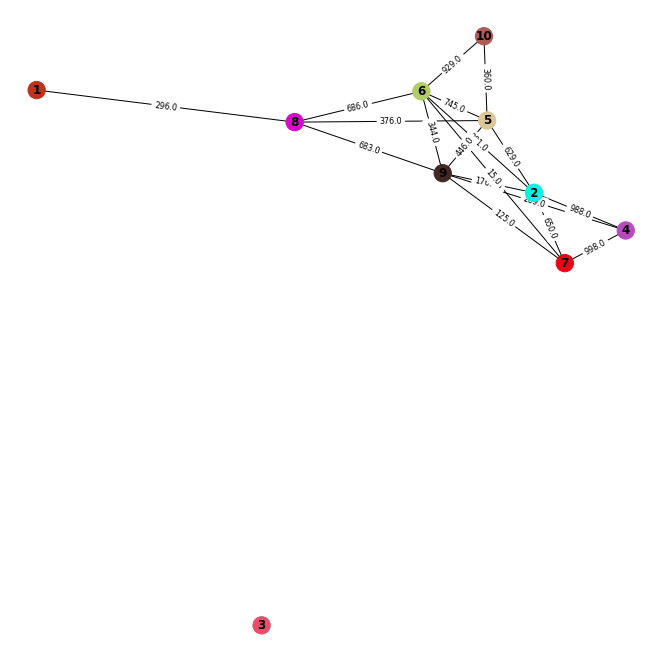

Using conditional entropy:
The Best K =  10
Measure =  0.0
Internal traffic for cluster  0  =  0.0
Internal traffic for cluster  1  =  0.0
Internal traffic for cluster  2  =  0.0
Internal traffic for cluster  3  =  0.0
Internal traffic for cluster  4  =  0.0
Internal traffic for cluster  5  =  0.0
Internal traffic for cluster  6  =  0.0
Internal traffic for cluster  7  =  0.0
Internal traffic for cluster  8  =  0.0
Internal traffic for cluster  9  =  0.0
sum of the cut weights =  21004.0
visualizing topology


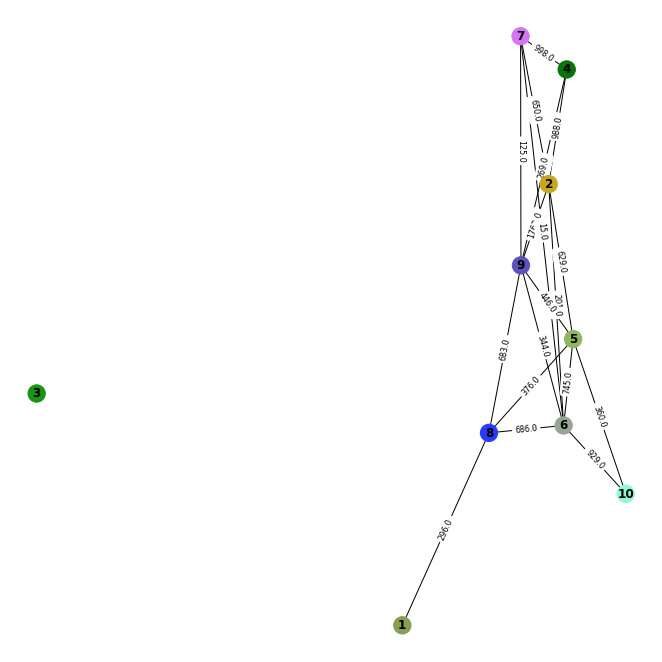

---------------------
---------------------
Sample number  1  :
Using F measure:
The Best K =  4
Measure =  0.5069444444444444
Internal traffic for cluster  0  =  917.0
Internal traffic for cluster  1  =  2569.0
Internal traffic for cluster  2  =  639.0
Internal traffic for cluster  3  =  1115.0
sum of the cut weights =  8032.0
visualizing topology


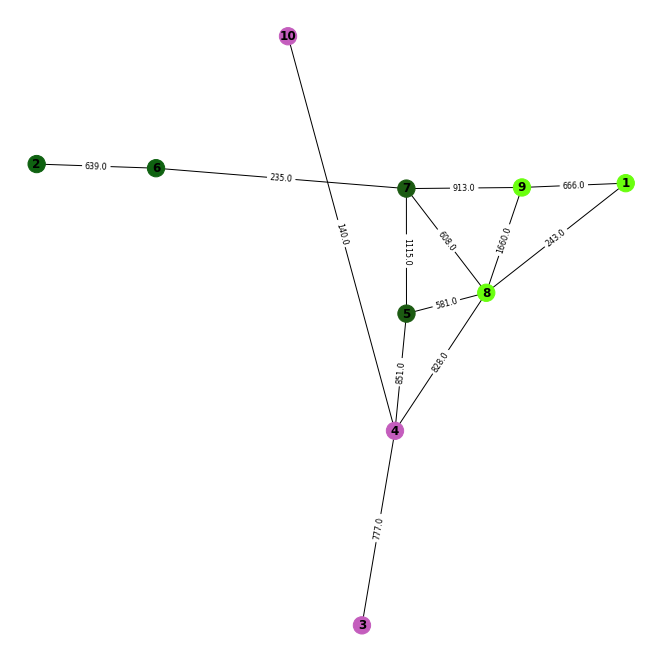

Using conditional entropy:
The Best K =  10
Measure =  0.0
Internal traffic for cluster  0  =  0.0
Internal traffic for cluster  1  =  0.0
Internal traffic for cluster  2  =  0.0
Internal traffic for cluster  3  =  0.0
Internal traffic for cluster  4  =  0.0
Internal traffic for cluster  5  =  0.0
Internal traffic for cluster  6  =  0.0
Internal traffic for cluster  7  =  0.0
Internal traffic for cluster  8  =  0.0
Internal traffic for cluster  9  =  0.0
sum of the cut weights =  18512.0
visualizing topology


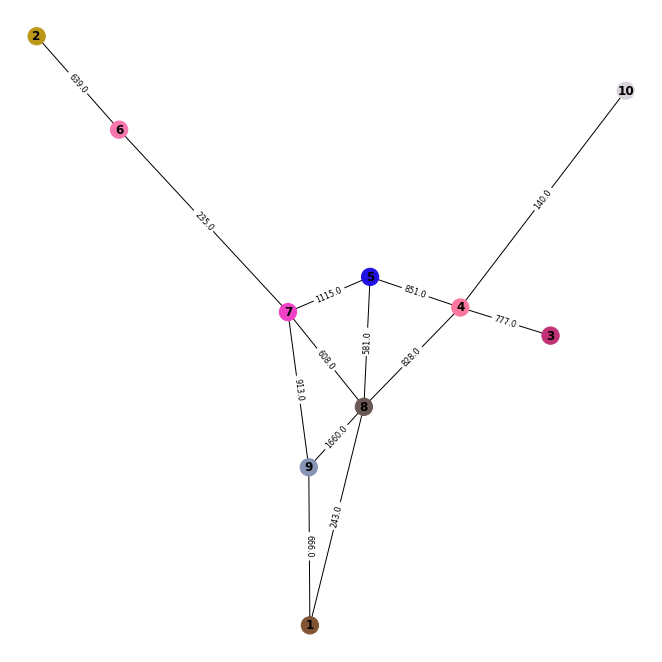

---------------------
---------------------
Sample number  2  :
Using F measure:
The Best K =  2
Measure =  0.6190476190476191
Internal traffic for cluster  0  =  2653.0
Internal traffic for cluster  1  =  5988.0
sum of the cut weights =  3386.0
visualizing topology


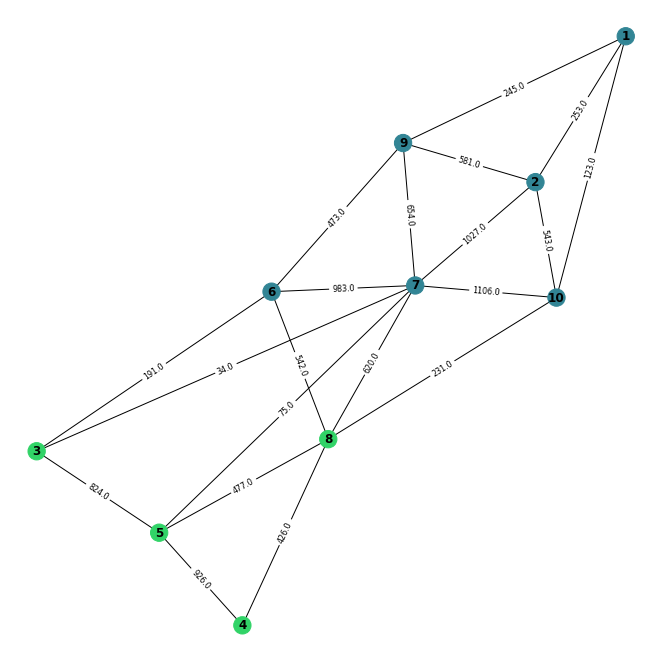

Using conditional entropy:
The Best K =  10
Measure =  0.0
Internal traffic for cluster  0  =  0.0
Internal traffic for cluster  1  =  0.0
Internal traffic for cluster  2  =  0.0
Internal traffic for cluster  3  =  0.0
Internal traffic for cluster  4  =  0.0
Internal traffic for cluster  5  =  0.0
Internal traffic for cluster  6  =  0.0
Internal traffic for cluster  7  =  0.0
Internal traffic for cluster  8  =  0.0
Internal traffic for cluster  9  =  0.0
sum of the cut weights =  20668.0
visualizing topology


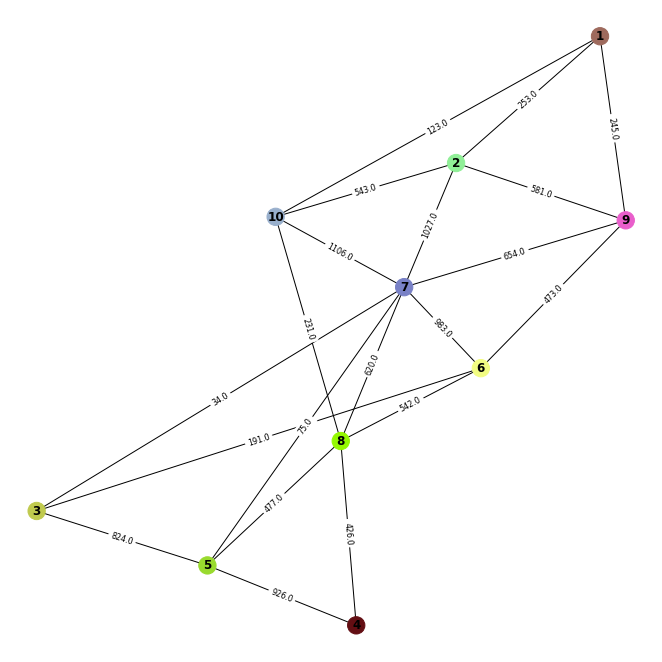

---------------------
---------------------
Sample number  3  :
Using F measure:
The Best K =  2
Measure =  0.48214285714285715
Internal traffic for cluster  0  =  7085.0
Internal traffic for cluster  1  =  163.0
sum of the cut weights =  0.0
visualizing topology


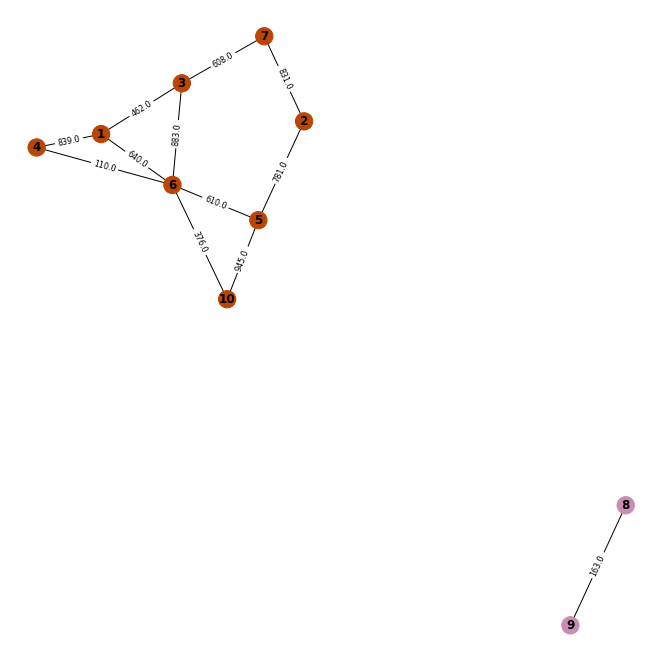

Using conditional entropy:
The Best K =  10
Measure =  0.0
Internal traffic for cluster  0  =  0.0
Internal traffic for cluster  1  =  0.0
Internal traffic for cluster  2  =  0.0
Internal traffic for cluster  3  =  0.0
Internal traffic for cluster  4  =  0.0
Internal traffic for cluster  5  =  0.0
Internal traffic for cluster  6  =  0.0
Internal traffic for cluster  7  =  0.0
Internal traffic for cluster  8  =  0.0
Internal traffic for cluster  9  =  0.0
sum of the cut weights =  14496.0
visualizing topology


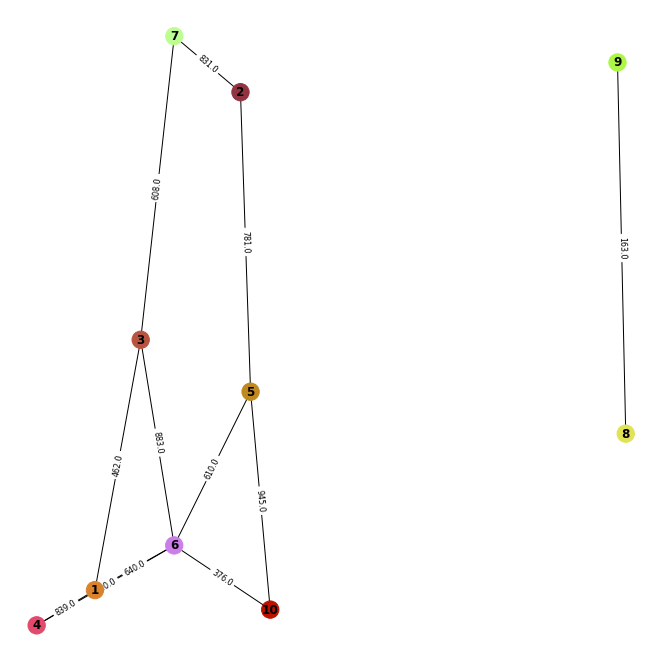

---------------------
---------------------


In [58]:
measure(topol10, gt1, [2,4,6,8,10], 4)

## Evaluation of topologies of size 50

Sample number  0  :
Using F measure:
The Best K =  10
Measure =  0.3731009341535657
Internal traffic for cluster  0  =  1998.0
Internal traffic for cluster  1  =  0.0
Internal traffic for cluster  2  =  2099.0
Internal traffic for cluster  3  =  8155.0
Internal traffic for cluster  4  =  3399.0
Internal traffic for cluster  5  =  0.0
Internal traffic for cluster  6  =  246.0
Internal traffic for cluster  7  =  5480.0
Internal traffic for cluster  8  =  0.0
Internal traffic for cluster  9  =  0.0
sum of the cut weights =  4838.0
visualizing topology


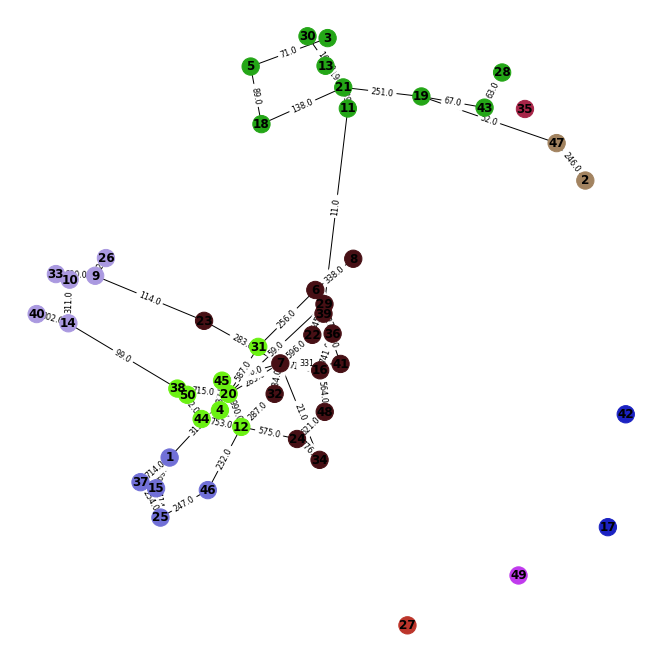

Using conditional entropy:
The Best K =  25
Measure =  0.3055748712940425
Internal traffic for cluster  0  =  247.0
Internal traffic for cluster  1  =  2286.0
Internal traffic for cluster  2  =  0.0
Internal traffic for cluster  3  =  0.0
Internal traffic for cluster  4  =  338.0
Internal traffic for cluster  5  =  564.0
Internal traffic for cluster  6  =  753.0
Internal traffic for cluster  7  =  1348.0
Internal traffic for cluster  8  =  1139.0
Internal traffic for cluster  9  =  801.0
Internal traffic for cluster  10  =  827.0
Internal traffic for cluster  11  =  1383.0
Internal traffic for cluster  12  =  532.0
Internal traffic for cluster  13  =  776.0
Internal traffic for cluster  14  =  71.0
Internal traffic for cluster  15  =  587.0
Internal traffic for cluster  16  =  246.0
Internal traffic for cluster  17  =  0.0
Internal traffic for cluster  18  =  0.0
Internal traffic for cluster  19  =  63.0
Internal traffic for cluster  20  =  0.0
Internal traffic for cluster  21  =  0.0


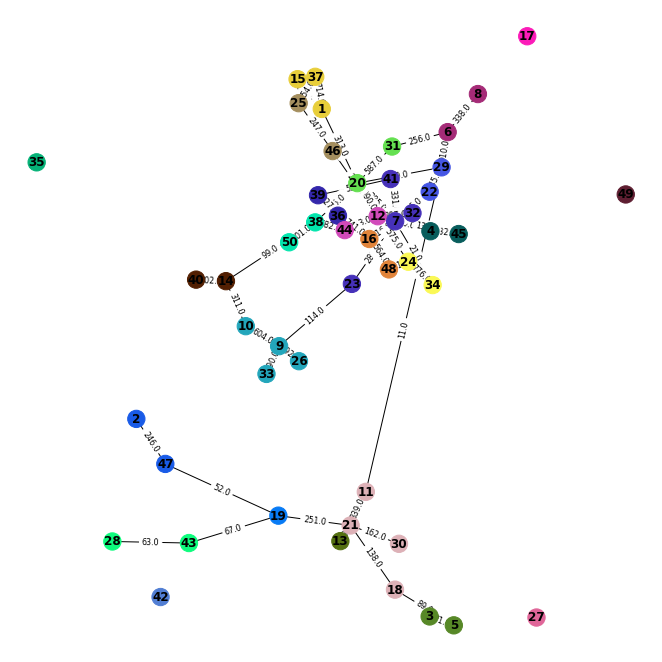

---------------------
---------------------
Sample number  1  :
Using F measure:
The Best K =  25
Measure =  0.40247619047619054
Internal traffic for cluster  0  =  757.0
Internal traffic for cluster  1  =  986.0
Internal traffic for cluster  2  =  0.0
Internal traffic for cluster  3  =  432.0
Internal traffic for cluster  4  =  482.0
Internal traffic for cluster  5  =  1132.0
Internal traffic for cluster  6  =  717.0
Internal traffic for cluster  7  =  1784.0
Internal traffic for cluster  8  =  0.0
Internal traffic for cluster  9  =  2315.0
Internal traffic for cluster  10  =  868.0
Internal traffic for cluster  11  =  472.0
Internal traffic for cluster  12  =  438.0
Internal traffic for cluster  13  =  760.0
Internal traffic for cluster  14  =  997.0
Internal traffic for cluster  15  =  909.0
Internal traffic for cluster  16  =  709.0
Internal traffic for cluster  17  =  714.0
Internal traffic for cluster  18  =  844.0
Internal traffic for cluster  19  =  178.0
Internal traffic for c

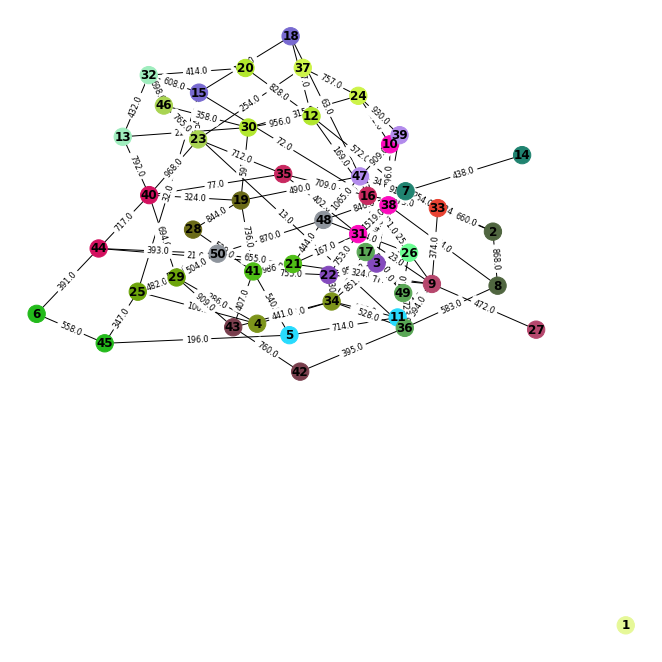

Using conditional entropy:
The Best K =  25
Measure =  0.3026234227276057
Internal traffic for cluster  0  =  757.0
Internal traffic for cluster  1  =  986.0
Internal traffic for cluster  2  =  0.0
Internal traffic for cluster  3  =  432.0
Internal traffic for cluster  4  =  482.0
Internal traffic for cluster  5  =  1132.0
Internal traffic for cluster  6  =  717.0
Internal traffic for cluster  7  =  1784.0
Internal traffic for cluster  8  =  0.0
Internal traffic for cluster  9  =  2315.0
Internal traffic for cluster  10  =  868.0
Internal traffic for cluster  11  =  472.0
Internal traffic for cluster  12  =  438.0
Internal traffic for cluster  13  =  760.0
Internal traffic for cluster  14  =  997.0
Internal traffic for cluster  15  =  909.0
Internal traffic for cluster  16  =  709.0
Internal traffic for cluster  17  =  714.0
Internal traffic for cluster  18  =  844.0
Internal traffic for cluster  19  =  178.0
Internal traffic for cluster  20  =  558.0
Internal traffic for cluster  21  

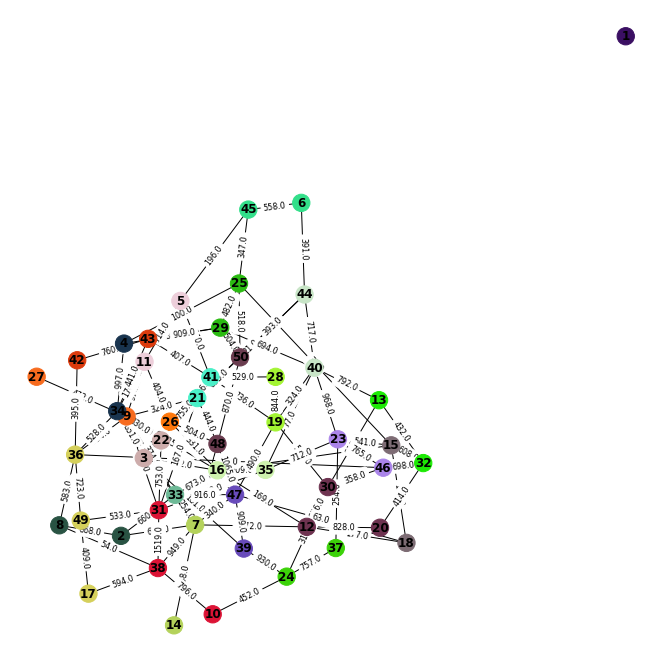

---------------------
---------------------


In [59]:
measure(topol50, gt2, [2,10,12,15,17,20,25], 2)

## Evaluation of topologies of size 100

In [60]:
def measure100(topologies, kValues, noOfSmapleToTest):
  for i in range(noOfSmapleToTest):
    print("Sample number ", i , " :")
    
    # 0 index for 
    bestMeasures = [0]
    bestK = [0]
    bestCPredected = [0]
    for k in kValues:
      CPredected = Kmeans(specturalClustring(topologies[i], k), k)
      NC = normalizedCutEval(CPredected, topol100[i])
      if   NC > bestMeasures[0]:
        bestMeasures[0] = NC
        bestK[0] = k
        bestCPredected[0] = CPredected
    print("Using NC measure:")
    printStatistics(3, topologies[i], bestMeasures,  bestK, bestCPredected)

    print("---------------------")
    print("---------------------") 


Sample number  0  :
Using NC measure:
The Best K =  25
Measure =  24.988386256159668
Internal traffic for cluster  0  =  7572.0
Internal traffic for cluster  1  =  7975.0
Internal traffic for cluster  2  =  817.0
Internal traffic for cluster  3  =  3314.0
Internal traffic for cluster  4  =  2418.0
Internal traffic for cluster  5  =  4355.0
Internal traffic for cluster  6  =  5923.0
Internal traffic for cluster  7  =  7056.0
Internal traffic for cluster  8  =  4176.0
Internal traffic for cluster  9  =  2508.0
Internal traffic for cluster  10  =  6855.0
Internal traffic for cluster  11  =  1941.0
Internal traffic for cluster  12  =  3729.0
Internal traffic for cluster  13  =  3702.0
Internal traffic for cluster  14  =  1357.0
Internal traffic for cluster  15  =  1999.0
Internal traffic for cluster  16  =  2535.0
Internal traffic for cluster  17  =  914.0
Internal traffic for cluster  18  =  2235.0
Internal traffic for cluster  19  =  3960.0
Internal traffic for cluster  20  =  2693.0
Int

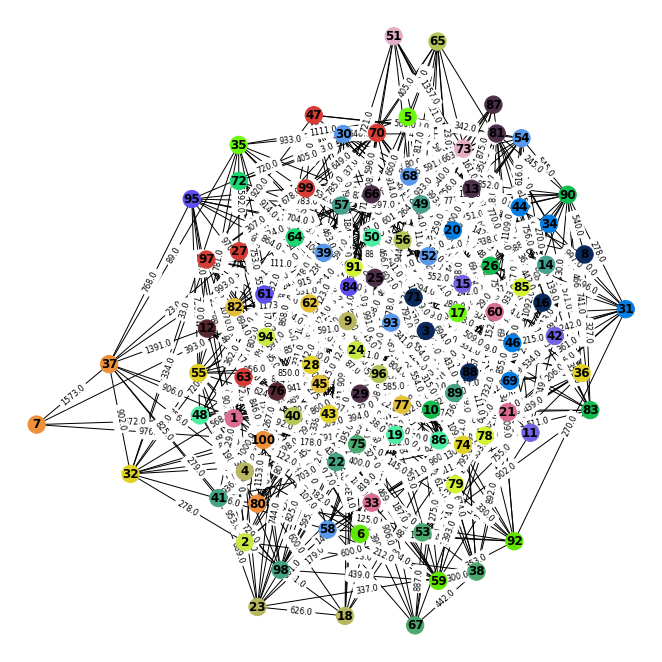

---------------------
---------------------


In [61]:
measure100(topol100, [2,10,12,15,17,20,25], 1)

In [62]:
a = np.array([1, 2]).reshape((1, 2))

for row in a :
  row = row / 5

a

array([[1, 2]])